In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr

from pointprocess import *
from lightning_setup import *
%matplotlib inline

EPK only because that is the area for which we have precipitable water data

In [2]:
c = Region(city=cities['cedar'])
c.SUBSETTED = False
c.CENTER = (37.7, -111.8)
c.RADIUS = 0.6
c.define_grid()

version1 = pd.HDFStore('./output/Version1/store.h5')

In [3]:
ds = c.get_ds(y=2014, filter_CG=dict(method='less_than', amax=-10), func=None)

In [4]:
times = pd.DatetimeIndex(ds.time.values)

In [5]:
decimal_doy =  times.dayofyear + times.hour/24.+times.minute/(60*24.)+times.second/(60*60*24.)+times.nanosecond/(10000000*60*60*24.)

In [6]:
def dateparser(y, j, t):
    x = ' '.join([y, str(int(float(j))), t])
    return pd.datetime.strptime(x, '%Y %j %H:%M:%S')

df = pd.read_csv('./input/pwv147215720409387.txt', delim_whitespace=True, skiprows=[1], na_values=[-9.99],
                 parse_dates={'time': [1,2,3]}, date_parser=dateparser, index_col='time')

In [7]:
ipw = df.IPW

In [9]:
%%time
ipw_nearest = ipw.reindex(times, method='nearest')

CPU times: user 1.61 ms, sys: 0 ns, total: 1.61 ms
Wall time: 1.11 ms


In [10]:
from collections import OrderedDict

d = {'YYYY': times.year[1:],
     'DOY': times.dayofyear[1:],
     'DURATION': decimal_doy[1:]-decimal_doy[:-1],
     'EVENT': 1,  
     'X1': ipw_nearest[1:]}

OD = OrderedDict([(k, d[k]) for k in ['DURATION', 'EVENT', 'X1', 'DOY']])
cox_df = pd.DataFrame(OD)

cox_df.dropna(how='any', inplace=True)

In [11]:
from lifelines import CoxPHFitter
cf = CoxPHFitter()

In [12]:
cf.fit(cox_df, 'DURATION', 'EVENT')

<lifelines.CoxPHFitter: fitted with 9486 observations, 0 censored>

In [13]:
cf.print_summary()

n=9486, number of events=9486

         coef  exp(coef)  se(coef)         z         p  lower 0.95  upper 0.95     
X1  1.103e-01  1.117e+00 9.165e-03 1.204e+01 2.291e-33   9.235e-02   1.283e-01  ***
DOY 6.028e-02  1.062e+00 9.642e-03 6.252e+00 4.053e-10   4.138e-02   7.918e-02  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.537


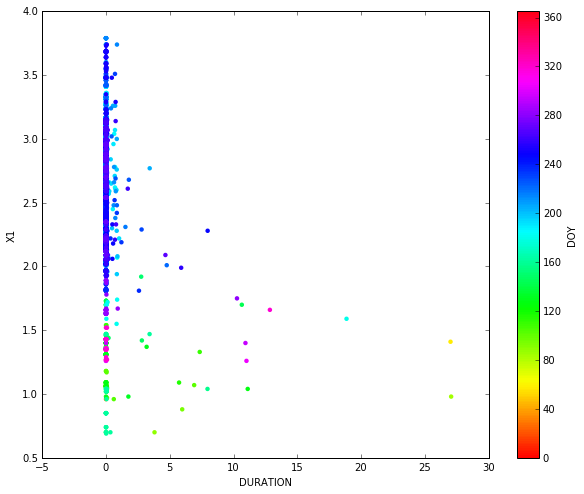

In [17]:
cox_df.plot.scatter(x='DURATION', y='X1', c='DOY', sharex=False, cmap='hsv', vmin=0, vmax=365, edgecolor='None', figsize=(10,8));